
# Importing Packages

In [1]:
!pip install tensorflow==2.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [2]:
import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

2024-04-26 07:57:35.317776: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 07:57:35.317829: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 07:57:35.319239: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print(tf.__version__)

2.15.1


# Data Importing

In [4]:
data_dir = "/kaggle/input/handwritten-marathi-character-augmented-dataset/Numbers"
data_dir = pathlib.Path(data_dir)
print(data_dir)

/kaggle/input/handwritten-marathi-character-augmented-dataset/Numbers


/kaggle/input/handwritten-marathi-character-augmented-dataset/Numbers/C57/C57_3.jpg


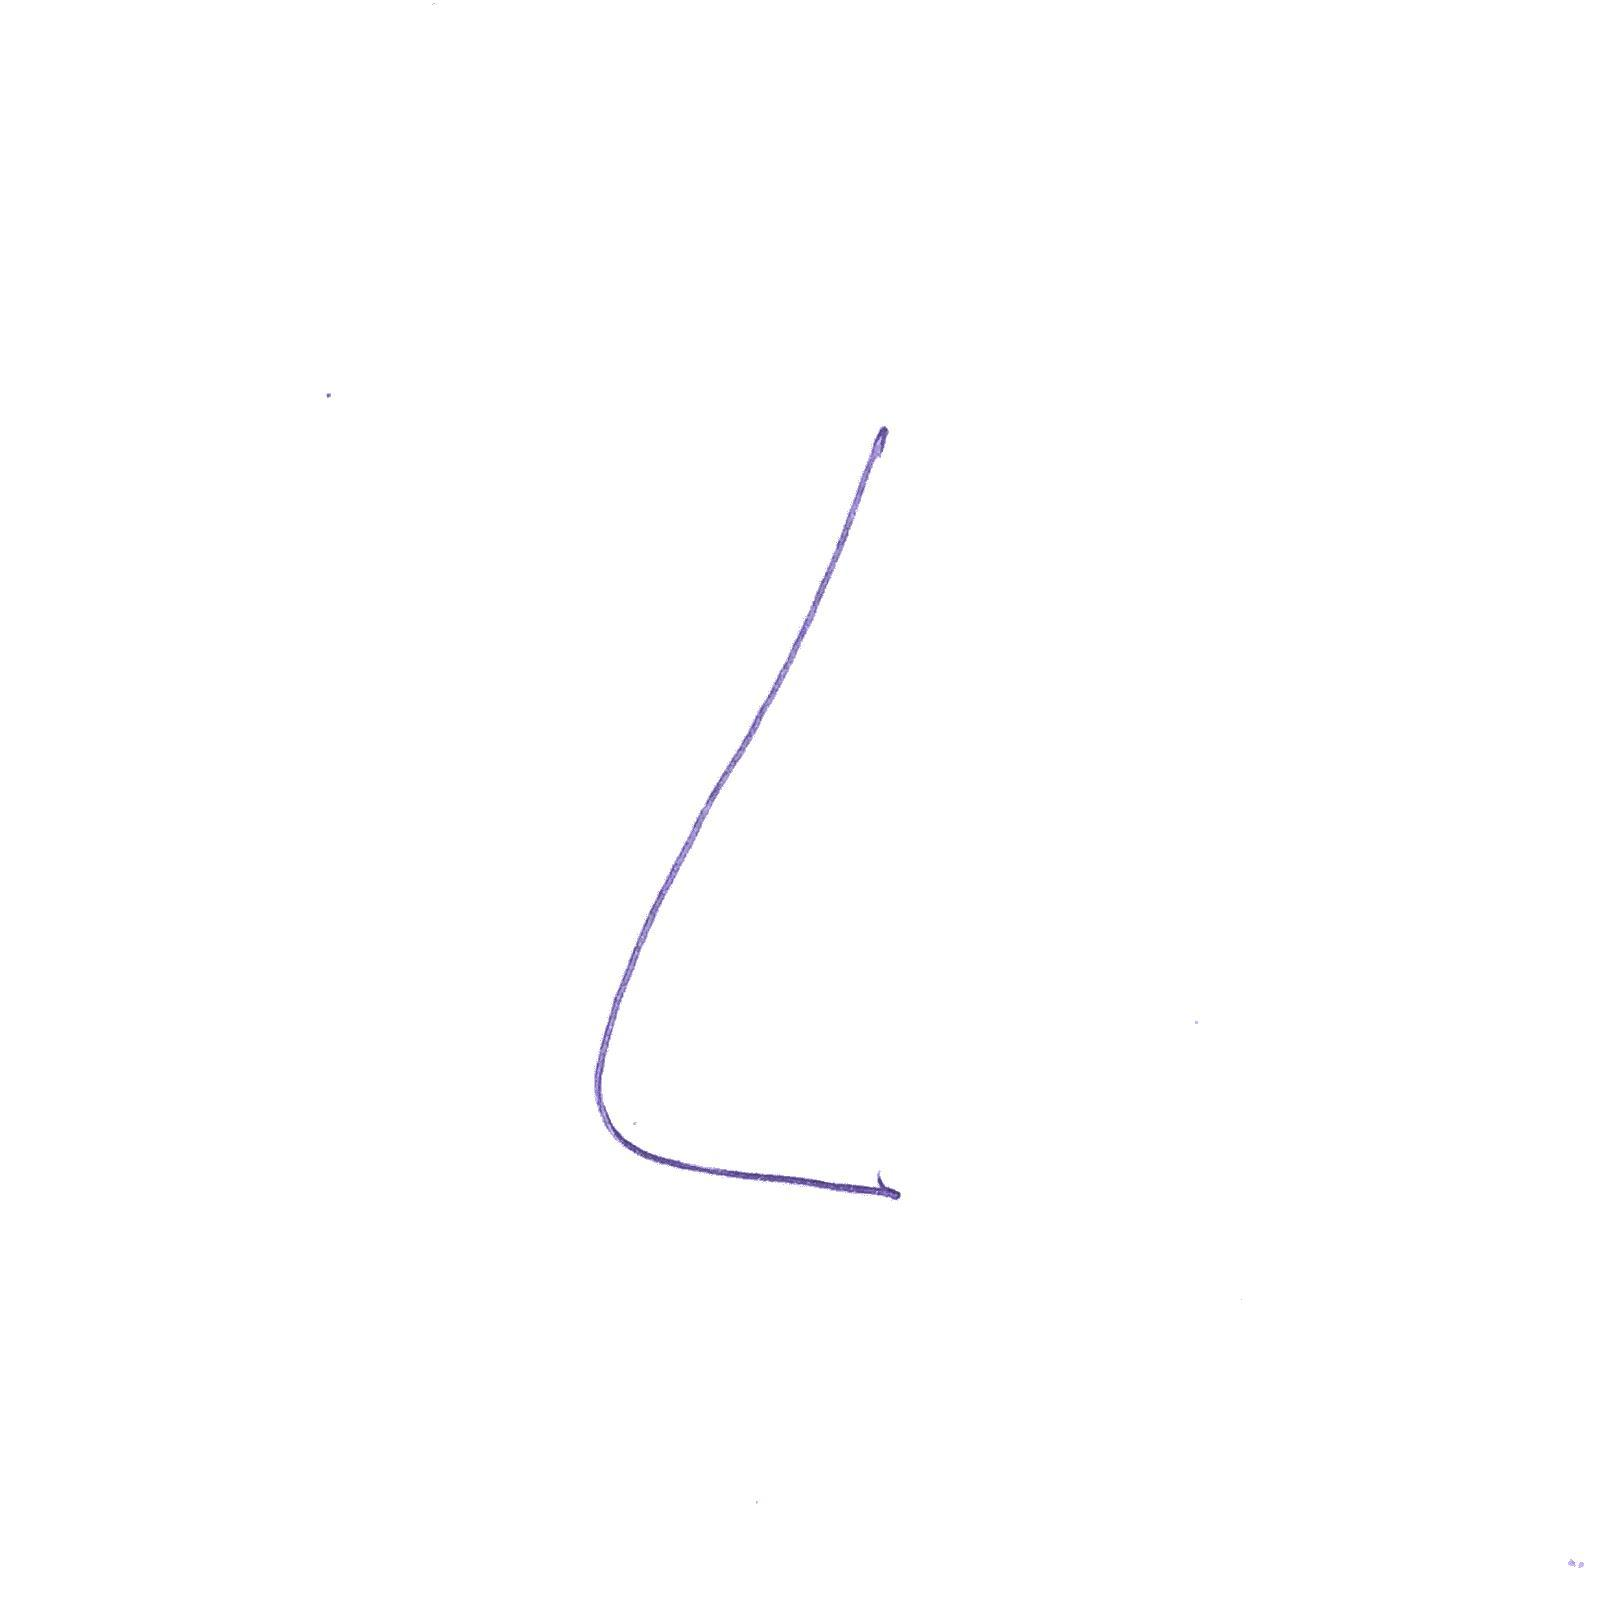

In [5]:
ch1 = list(data_dir.glob('C57/*'))
print(ch1[0])
PIL.Image.open(str(ch1[0]))

# Data Preprocessig

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height,img_width=224,224
batch_size =32

# Define data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25,
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
)


# Prepare training dataset with data augmentation
train_ds = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=123
)

# Prepare validation dataset without data augmentation
val_ds = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=123
)

Found 4500 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.


In [7]:
class_indices = train_ds.class_indices
class_names = {v: k for k, v in class_indices.items()}
print(class_names)

{0: 'C49', 1: 'C50', 2: 'C51', 3: 'C52', 4: 'C53', 5: 'C54', 6: 'C55', 7: 'C56', 8: 'C57', 9: 'C58'}


# Develop Model

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam


# Model modification
model = Sequential([
    ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3)),
    GlobalAveragePooling2D(),
    # Here, we introduce additional Dense layers.
    Dense(1024, activation="relu"),  # A dense layer with 1024 units and 'relu' activation.
    Dropout(0.5),                     # A dropout layer for regularization (optional).
    Dense(512, activation="relu"),   # Another dense layer with 512 units.
    Dropout(0.5),                     # Another dropout layer for regularization (optional).
    
    Dense(10, activation="softmax")
])
customize_optimizer = Adam(lr=0.001)

model.compile(optimizer=customize_optimizer , loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 0s 0us/step


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

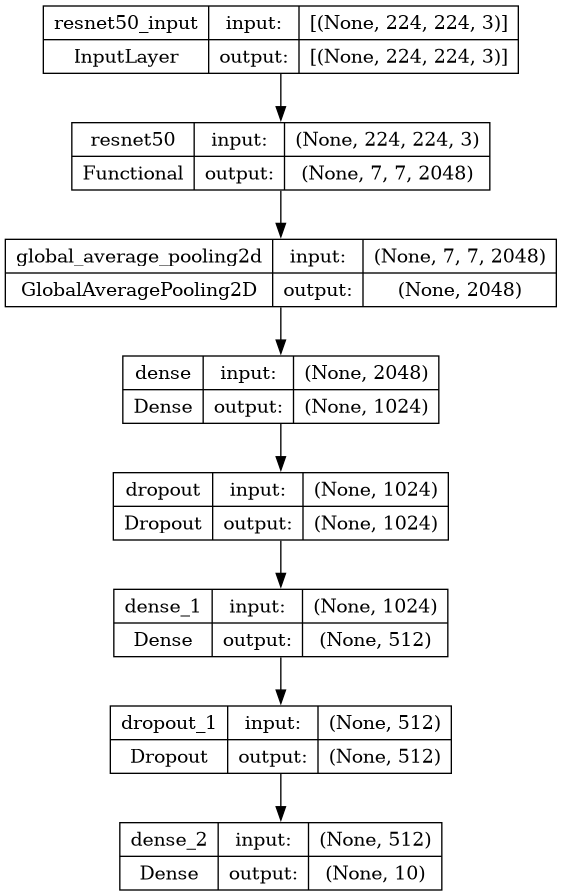

In [10]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Train Model

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint
# creating checkpoints
model_path = "/kaggle/working/MNCR_best_model_M1_V1.h5"

# Define the checkpoint
checkpoint = ModelCheckpoint(model_path, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

In [12]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint]  
)

Epoch 1/20


I0000 00:00:1714118286.856146      93 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


141/141 [==============================] - ETA: 0s - loss: 0.6829 - accuracy: 0.7998
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to /kaggle/working/MNCR_best_model_M1_V1.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


141/141 [==============================] - 128s 643ms/step - loss: 0.6829 - accuracy: 0.7998 - val_loss: 2.3206 - val_accuracy: 0.1000
Epoch 2/20
141/141 [==============================] - ETA: 0s - loss: 0.2218 - accuracy: 0.9444
Epoch 2: val_accuracy did not improve from 0.10000
141/141 [==============================] - 56s 396ms/step - loss: 0.2218 - accuracy: 0.9444 - val_loss: 2.4137 - val_accuracy: 0.1000
Epoch 3/20
141/141 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9762
Epoch 3: val_accuracy did not improve from 0.10000
141/141 [==============================] - 56s 395ms/step - loss: 0.0973 - accuracy: 0.9762 - val_loss: 2.4293 - val_accuracy: 0.1000
Epoch 4/20
141/141 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 0.9776
Epoch 4: val_accuracy did not improve from 0.10000
141/141 [==============================] - 59s 416ms/step - loss: 0.0868 - accuracy: 0.9776 - val_loss: 2.3131 - val_accuracy: 0.1000
Epoch 5/20
141/141 [==

# Model Evaluation / Testing

In [13]:
from tensorflow.keras.models import load_model

# Load the model
best_model = load_model('/kaggle/working/MNCR_best_model_M1_V1.h5')


In [14]:
test_dir = '/kaggle/input/testingdataset/Numbers'

test_data = train_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 400 images belonging to 10 classes.


In [15]:
result = best_model.evaluate(test_data)
print(result)

13/13 [==============================] - 5s 274ms/step - loss: 0.2447 - accuracy: 0.9400
[0.24473199248313904, 0.9399999976158142]
